In [2]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt

import sklearn
import sklearn.metrics
import sklearn.model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# Explore ResNet feature matrices
image_folder = "train_input/resnet_features/"
#image = np.load('/tmp/123.npy', mmap_mode='r')

# Function to load folder into arrays and then it returns that same array
def loadImages(path):
    image_files = sorted([os.path.join(path, file)
         for file in os.listdir(path) if file.endswith('.npy')])
    return image_files

In [4]:
# Check number of images in training set
len(loadImages(image_folder))

279

In [5]:
# load first npy and explore data
npy_train = loadImages(image_folder)
matrix_npy = np.load(npy_train[0], mmap_mode='r')

In [6]:
def get_average_features(filenames):
    """Load and aggregate the resnet features by the average.

    Args:
        filenames: list of filenames of length `num_patients` corresponding to resnet features

    Returns:
        features: np.array of mean resnet features, shape `(num_patients, 2048)`
    """
    # Load numpy arrays
    features = []
    for f in filenames:
        patient_features = np.load(f)

        # Remove location features (but we could use them?)
        patient_features = patient_features[:, 3:]

        aggregated_features = np.mean(patient_features, axis=0)
        features.append(aggregated_features)

    features = np.stack(features, axis=0)
    return features

In [7]:
# load feature npy folder into arrays and then it returns that same array of strings
def loadFiles(path):
    feature_files = sorted([os.path.join(path, file)
         for file in os.listdir(path) if file.endswith('.npy')])
    return feature_files

In [8]:
# precise training set and test set relative location
train_dir = Path("train_input/resnet_features")
test_dir = Path("test_input/resnet_features")

train_output_filename = Path("training_output.csv")

train_output = pd.read_csv(train_output_filename)

In [9]:
# Get filenames for train
filenames_train = loadFiles(train_dir)

# Get global labels (patient-wise) for train
labels_train = train_output["Target"].values

# check if the number of observations and labels corresponds
assert len(filenames_train) == len(labels_train)

In [10]:
# Get the numpy filenames for test
filenames_test = loadFiles(test_dir)
# ID list without its suffix (ex: "ID_005")
ids_test = [Path(f).stem for f in filenames_test]

In [11]:
# Get the resnet features and aggregate them by the average
features_train = get_average_features(filenames_train)
features_test = get_average_features(filenames_test)

<h2>Determine the right NB of dimensions</h2>

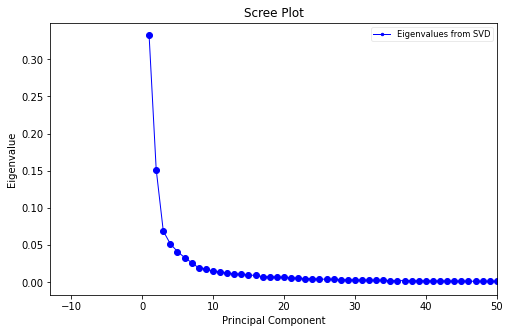

In [41]:
# Standardise data
X_std = StandardScaler().fit_transform(features_train)

num_vars = len(loadImages(image_folder))

U, S, V = np.linalg.svd(X_std) 
eigvals = S**2 / np.sum(S**2)  # NOTE (@amoeba): These are not PCA eigenvalues. 
                               # This question is about SVD.

fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(num_vars) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=1, c='blue')
plt.xlim(right = 50)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
#leg.draggable(state=True)
plt.show()

<p style="font-weight: bold">From the above scree, we observe a plateau starting from the 25th to 30th components, implying that we could reduce the data to 25-30 dimensions arbitrarily. But considering that the differences between consecutive eigenvalues are relatively small to draw an optimal conclusion, another more quantitative way to determine number of principle components is to apply the "90% Rule" on eigenvalues of standardised data.</p>

In [13]:
# Standardise data
X_std = StandardScaler().fit_transform(features_train)

# Covariance Matrix and Eigendecomposition from standardised data
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00359712 -0.22319086 -0.49512555 ...  0.34515686  0.07767093
  -0.5004869 ]
 [-0.22319086  1.00359712 -0.00761793 ...  0.40279364  0.70584395
   0.09100338]
 [-0.49512555 -0.00761793  1.00359712 ... -0.4715814  -0.41483599
   0.65529491]
 ...
 [ 0.34515686  0.40279364 -0.4715814  ...  1.00359712  0.66842232
  -0.37066318]
 [ 0.07767093  0.70584395 -0.41483599 ...  0.66842232  1.00359712
  -0.32603747]
 [-0.5004869   0.09100338  0.65529491 ... -0.37066318 -0.32603747
   1.00359712]]


In [14]:
#Perform eigendecomposition on covariance matrix
# Each eigenvector has a corresponding eigenvalue, and the sum of the eigenvalues represents all of the variance within the entire dataset.
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.01449431+0.j          0.03321433+0.j          0.01341114+0.j
  ...  0.02378602-0.00889271j -0.00623819-0.00118527j
  -0.00623819+0.00118527j]
 [-0.01949248+0.j         -0.03831418+0.j         -0.0216992 +0.j
  ... -0.00161408+0.00037195j  0.00101766-0.0004602j
   0.00101766+0.0004602j ]
 [ 0.02505241+0.j         -0.02130636+0.j         -0.02971156+0.j
  ...  0.00128336-0.00053164j -0.0003685 +0.00013372j
  -0.0003685 -0.00013372j]
 ...
 [-0.03112981+0.j         -0.00063298+0.j         -0.01335913+0.j
  ...  0.01800428-0.00566185j  0.0013515 -0.00580267j
   0.0013515 +0.00580267j]
 [-0.03129833+0.j         -0.02038527+0.j         -0.00352936+0.j
  ...  0.01392417+0.00300383j  0.00360839+0.01878794j
   0.00360839-0.01878794j]
 [ 0.02025198+0.j         -0.02831978+0.j         -0.02308474+0.j
  ... -0.02709732+0.01157619j -0.01806636-0.02010784j
  -0.01806636+0.02010784j]]

Eigenvalues 
[6.82781347e+02+0.00000000e+00j 3.12099539e+02+0.00000000e+00j
 1.41968351e+02+0.0000

In [15]:
# Select principle components
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
682.7813467140091
312.09953895123914
141.9683508123317
106.34597213128082
85.48938251520434
68.70863363250439
54.853457843099264
39.89988308164215
37.85547378839665
30.639428501657154
29.31575992063332
25.6243586775536
23.615168232615197
22.68294069248299
20.639901716843838
19.2855098113371
16.14436008648756
15.860809083639579
14.642803272685386
13.94340776867838
12.768239820866798
11.707307862420778
10.544596698366147
10.443924958932005
9.367105524258427
8.685184944501723
8.271958482188639
7.475860015174674
7.344623262747601
6.860011227153916
6.495586696439009
5.845721264523982
5.743505915781211
5.476560030336296
5.300672386332466
5.130662912250787
4.931388025544394
4.692348658308864
4.455274392955613
4.320704032252424
4.001729982842082
3.8824390617535887
3.8319726764087045
3.7074860621716956
3.4030928313346065
3.3588810857261167
3.214113599983175
3.150036148761135
3.026924725204437
2.818270766520281
2.774175725286764
2.6050579857804075
2.4859808345180

8.114022736031623e-16
8.114022736031623e-16
9.99349362082838e-16
6.666300236544764e-16
6.666300236544764e-16
6.904262796720689e-16
6.904262796720689e-16
7.485928178572424e-16
7.485928178572424e-16
8.059072996422616e-16
8.059072996422616e-16
7.543000470031515e-16
7.316941067036233e-16
7.316941067036233e-16
5.49848818758734e-16
5.49848818758734e-16
7.185617055960722e-16
7.185617055960722e-16
5.164412122782262e-16
5.164412122782262e-16
4.761331675597837e-16
4.761331675597837e-16
4.831321247234269e-16
4.831321247234269e-16
7.673090010027341e-16
6.30413496802891e-16
6.30413496802891e-16
5.494030354882382e-16
5.494030354882382e-16
6.115239880071508e-16
6.115239880071508e-16
6.87632840708195e-16
3.552741860797383e-16
3.552741860797383e-16
6.066829853821436e-16
6.066829853821436e-16
5.149578899336497e-16
5.149578899336497e-16
4.0433271712046143e-16
4.0433271712046143e-16
3.8028327026277863e-16
2.838799796360558e-16
2.838799796360558e-16
2.2461614545320167e-16
2.2461614545320167e-16
4.683094414

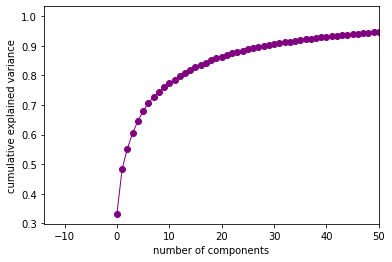

In [16]:
#Explained variance
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_),'ro-', linewidth=1, c='purple')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim(right=50)
plt.show()

<p style="font-weight: bold">Having performed a standardised eigenvalue cumulative plot, we observe that the first 29 or 30 elements describe most of the variation (information) within the data, meaning a major dimension reduction from the initial 2,048 features. </p>

<h2>Apply PCA and LDA</h2>

In [35]:
# Standardise data
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(features_train)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(features_train)
test_X = scaler.transform(features_test)

In [38]:
# instantiate PCA with determined dimension
pca = PCA(n_components=35)

# fit train data to PCA
pca.fit(train_X)

#  the mapping (transform) to both the training set and the test set
train_X = pca.transform(train_X)
test_X = pca.transform(test_X)

In [45]:
# Use the average resnet features to predict the labels

# number of runs for cross-validation
num_runs = 5
# number of splits for cross-validation
num_splits = 20

# Multiple cross validations on the training set
aucs = []
for seed in range(num_runs):
    # Use linear Discriminant Analysis
    model = LinearDiscriminantAnalysis()

    cv = sklearn.model_selection.StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=seed)

    # Cross validation on the training set
    auc = sklearn.model_selection.cross_val_score(model, X=train_X, y=labels_train,
                                                  cv=cv, scoring="roc_auc", verbose=0)
    
    aucs.append(auc)

aucs = np.array(aucs)

print("Predicting weak labels by mean resnet")
print("AUC: mean {}, std {}".format(aucs.mean(), aucs.std()))

Predicting weak labels by mean resnet
AUC: mean 0.71325, std 0.13391891376113743


In [48]:
# Prediction on the test set

# Train a final model on the full training set
estimator = LinearDiscriminantAnalysis()
estimator.fit(features_train, labels_train)

preds_test = estimator.predict_proba(features_test)[:, 1]

# Check that predictions are in [0, 1]
assert np.max(preds_test) <= 1.0
assert np.min(preds_test) >= 0.0

# -------------------------------------------------------------------------
# Write the predictions in a csv file, to export them in the suitable format
# to the data challenge platform
ids_number_test = [i.split("ID_")[1] for i in ids_test]
test_output = pd.DataFrame({"ID": ids_number_test, "Target": preds_test})
test_output.set_index("ID", inplace=True)
test_output.to_csv("predictions/preds_PCA_lda.csv")


<h2>Tune LDA hyperparameters with grid search</h2>

In [47]:
# Use the average resnet features to predict the labels

# number of runs for cross-validation
num_runs = 5
# number of splits for cross-validation
num_splits = 20

# Multiple cross validations on the training set

# Use linear Discriminant Analysis
model = LinearDiscriminantAnalysis()

cv = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=num_splits, n_repeats=num_runs, random_state=1)

# define grid
grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']
# define search
search = sklearn.model_selection.GridSearchCV(model, grid, scoring='roc_auc', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X=train_X, y=labels_train)
    
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)


Mean Accuracy: 0.714
Config: {'solver': 'svd'}


<p>Finally the default solver gives best result over all solvers so no need to do another prediction.</p>